In [131]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation, thresholding, testingPipeline

import concurrent.futures
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
import math
import sklearn
from collections import defaultdict
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
# data init

# dataset
baseDatasetPath = "../data/datasets"
inclusionThreshold = 0.5
includedSims = 24

# iters to run
iters = 5

# snr
snrs = range(1,7)

#SDs to test
sdMuls = list(range(1, 6))

thresholdingRes = defaultdict(lambda: defaultdict(lambda: {}))

# gans
batchSize = 64

#separation
separationRes = {}
for i in range(1, iters + 1):
    separationRes[i] = []

#results
resultsPath = "../data/results"

In [96]:
# generate datasets

for i in range(1, iters + 1):
    print(f"Generating dataset for iteration {i}")
          
    for snr in snrs:
        print(f"Generating dataset with snr {snr}")

        trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader = preprocessing.gen_loaders( 
            batchSize,
            includedSims,
            doDrown=True,
            snr=snr,
            inclusionThreshold=inclusionThreshold
        )

        pickle.dump(trainSpikesLoader, open(f"{baseDatasetPath}/it-{i}-snr-{snr}-trainSpikesLoader.pickle", "wb"))
        pickle.dump(valSpikesLoader, open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "wb"))
        pickle.dump(testSpikesLoader, open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "wb"))
        pickle.dump(trainBgLoader, open(f"{baseDatasetPath}/it-{i}-snr-{snr}-trainBgLoader.pickle", "wb"))
        pickle.dump(valBgLoader, open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valBgLoader.pickle", "wb"))
        pickle.dump(testBgLoader, open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testBgLoader.pickle", "wb"))

Generating dataset for iteration 1
Generating dataset with snr 1
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating dataset with snr 2
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating dataset with snr 3
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating dataset with snr 4
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating dataset with snr 5
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating dataset with snr 6
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating dataset for iteration 2
Generating dataset with snr 1
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating dataset with snr 2
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,

In [156]:
# run thresholding pipeline iters times

for i in range(1, iters + 1):
    print(f"\nIteration {i}\n")
    
    for snr in snrs:
        print(f"\nThresholding dataset with snr {snr}\n")

        trainSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-trainSpikesLoader.pickle", "rb"))
        valSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
        testSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))
        trainBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-trainBgLoader.pickle", "rb"))
        valBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valBgLoader.pickle", "rb"))
        testBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testBgLoader.pickle", "rb"))

        mean, sd = thresholding.computeThreshold(trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader)

        for sdMul in sdMuls:
            pred = thresholding.thresholdDatasets(mean, sdMul * sd, testSpikesLoader, testBgLoader)

            labels = np.concatenate(([1 for _ in range(0,len(testSpikesLoader.dataset))],[0 for _ in range(0,len(testBgLoader.dataset))]),axis=0)

            confusionMatrix = testingPipeline.confusionMatrix(labels,pred)

            accuracy, sensitivity, specificity, f1 = testingPipeline.metrics(confusionMatrix)

            thresholdingRes[i][snr][sdMul] = [confusionMatrix, accuracy, sensitivity, specificity, f1]

            print(f"Results for {sdMul} sd")
            print(confusionMatrix)
            print(f"Accuracy: {accuracy}")
            print(f"Sensitivity: {sensitivity}")
            print(f"Specificity: {specificity}")

pickle.dump(thresholdingRes, open(f"{resultsPath}/thresholdingRes.pickle", "wb"))



Iteration 1


Thresholding dataset with snr 1

Results for 1 sd
[[   95 20559]
 [    9 20644]]
Accuracy: 0.5020698670927446
Sensitivity: 0.9995642279571975
Specificity: 0.004599593299118815
Results for 2 sd
[[ 2979 17675]
 [  672 19981]]
Accuracy: 0.5558379935604135
Sensitivity: 0.9674623541374134
Specificity: 0.1442335625060521
Results for 3 sd
[[ 9701 10953]
 [ 3574 17079]]
Accuracy: 0.6483162660081826
Sensitivity: 0.8269500798915412
Specificity: 0.4696911009973855
Results for 4 sd
[[15263  5391]
 [ 8149 12504]]
Accuracy: 0.6722105212191638
Sensitivity: 0.6054326248002712
Specificity: 0.7389851844678996
Results for 5 sd
[[18382  2272]
 [12397  8256]]
Accuracy: 0.6448785920061975
Sensitivity: 0.3997482205974919
Specificity: 0.8899970949937058

Thresholding dataset with snr 2

Results for 1 sd
[[  221 20433]
 [    0 20653]]
Accuracy: 0.505338078291815
Sensitivity: 1.0
Specificity: 0.010700106516897453
Results for 2 sd
[[ 4937 15717]
 [  292 20361]]
Accuracy: 0.6124385697339434
Sensiti

PicklingError: Can't pickle <function <lambda> at 0x7f648aee4160>: attribute lookup <lambda> on __main__ failed

In [168]:
thresholdingRes

defaultdict(<function __main__.<lambda>()>,
            {1: defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {1: {1: [array([[   95, 20559],
                                   [    9, 20644]]),
                            0.5020698670927446,
                            0.9995642279571975,
                            0.004599593299118815,
                            0.6674857734092084],
                           2: [array([[ 2979, 17675],
                                   [  672, 19981]]),
                            0.5558379935604135,
                            0.9674623541374134,
                            0.1442335625060521,
                            0.6853487454766846],
                           3: [array([[ 9701, 10953],
                                   [ 3574, 17079]]),
                            0.6483162660081826,
                            0.8269500798915412,
                            0.4696911009973855,
                      

In [181]:
# Interpret thresholding results
#avgs -> metric -> sd -> values for specific snr
avgs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

thIt = 0

for it in thresholdingRes:
    thIt += 1
    for snr in thresholdingRes[it]:
        for sd in thresholdingRes[it][snr]:
            avgs["accuracy"][sd][snr] += thresholdingRes[it][snr][sd][1]
            avgs["sensitivity"][sd][snr] += thresholdingRes[it][snr][sd][2]
            avgs["specificity"][sd][snr] += thresholdingRes[it][snr][sd][3]
            avgs["f1"][sd][snr] += thresholdingRes[it][snr][sd][4]
for metric in avgs:
    for sd in avgs[metric]:
        for snr in avgs[metric][sd]:
            avgs[metric][sd][snr] /= thIt
print(json.dumps(avgs["specificity"], indent=4))

{
    "1": {
        "1": 0.0046383267163745525,
        "2": 0.010932507020431876,
        "3": 0.020276943933378522,
        "4": 0.03256512055776121,
        "5": 0.04668345114747749,
        "6": 0.0633485039217585
    },
    "2": {
        "1": 0.14472741357606278,
        "2": 0.23881088409024884,
        "3": 0.3289725961072915,
        "4": 0.41251089377360317,
        "5": 0.48891255931054517,
        "6": 0.5567250895710274
    },
    "3": {
        "1": 0.4707078532003486,
        "2": 0.611068073980827,
        "3": 0.7136051128110777,
        "4": 0.7883993415319066,
        "5": 0.8406410380555824,
        "6": 0.8815338433233272
    },
    "4": {
        "1": 0.7412607727316742,
        "2": 0.845870049385107,
        "3": 0.9050643943061877,
        "4": 0.9398566863561537,
        "5": 0.9604919143991479,
        "6": 0.9744553113198412
    },
    "5": {
        "1": 0.8895516606952649,
        "2": 0.9462283334947227,
        "3": 0.9716955553403699,
        "4": 0.98

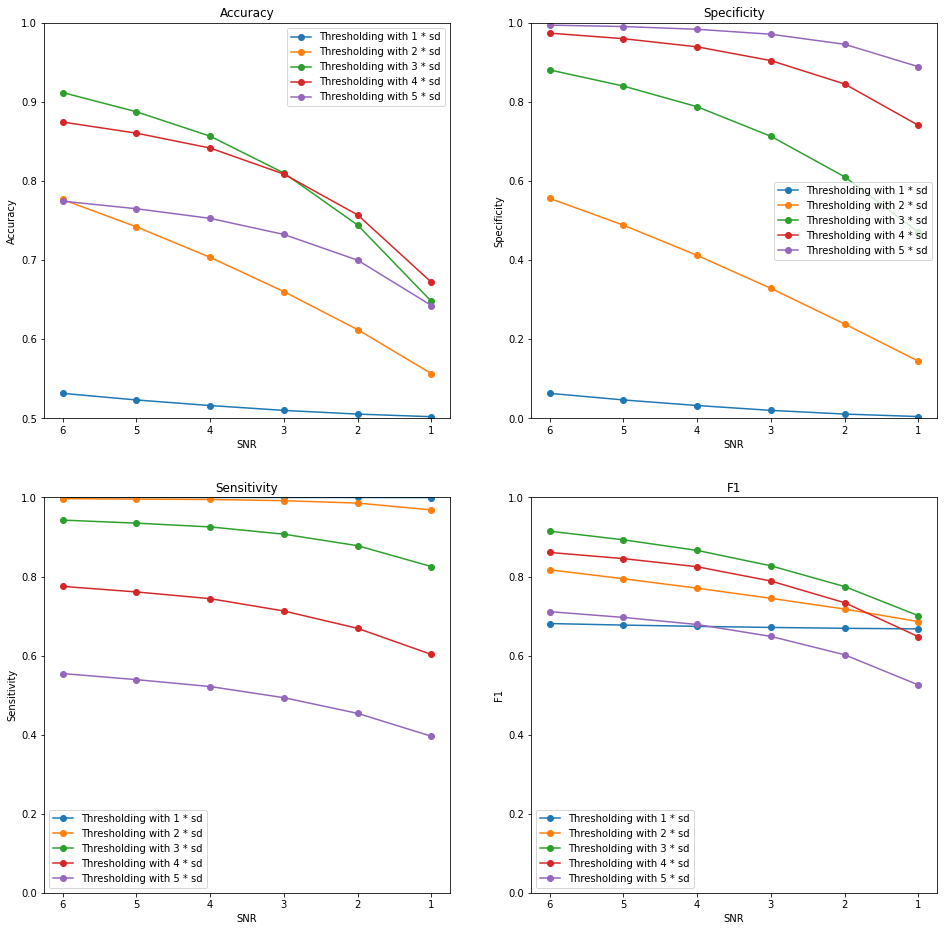

In [182]:
plt.rcParams['figure.figsize'] = [16, 16]

fig, axs = plt.subplots(2,2)

axs[0][0].title.set_text("Accuracy")
axs[0][1].title.set_text("Specificity")
axs[1][0].title.set_text("Sensitivity")
axs[1][1].title.set_text("F1")
axs[0][0].set_xlabel("SNR")
axs[0][1].set_xlabel("SNR")
axs[1][0].set_xlabel("SNR")
axs[1][1].set_xlabel("SNR")
axs[0][0].set_ylabel("Accuracy")
axs[0][1].set_ylabel("Specificity")
axs[1][0].set_ylabel("Sensitivity")
axs[1][1].set_ylabel("F1")

for sd in avgs["accuracy"]:
    axs[0][0].plot(avgs["accuracy"][sd].keys(), avgs["accuracy"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
for sd in avgs["specificity"]:
    axs[0][1].plot(avgs["specificity"][sd].keys(), avgs["specificity"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
for sd in avgs["sensitivity"]:
    axs[1][0].plot(avgs["sensitivity"][sd].keys(), avgs["sensitivity"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
for sd in avgs["f1"]:
    axs[1][1].plot(avgs["f1"][sd].keys(), avgs["f1"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')

axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()

axs[0][0].set_ylim([0.5,1])
axs[0][1].set_ylim([0,1])
axs[1][0].set_ylim([0,1])
axs[1][1].set_ylim([0,1])
axs[0][0].invert_xaxis()
axs[0][1].invert_xaxis()
axs[1][0].invert_xaxis()
axs[1][1].invert_xaxis()

plt.show()
plt.rcParams['figure.figsize'] = [16, 8]       

In [ ]:
# load gan models

toLoad1 = "orig"
gen1 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
critic1 = gans.CriticWgan(inputSize=80, hiddenSize=40)
gen1.load_state_dict(torch.load(f"../data/models/gen1.{toLoad1}.pth"))
gen1.to(gans.device)
critic1.load_state_dict(torch.load(f"../data/models/critic1.{toLoad1}.pth"))
critic1.to(gans.device)

gen2 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=10, outputSize=80)
critic2 = gans.CriticWgan(inputSize=80, hiddenSize=40)
gen2.load_state_dict(torch.load(f"../data/models/gen2.{toLoad1}.pth"))
gen2.to(gans.device)
critic2.load_state_dict(torch.load(f"../data/models/critic2.{toLoad1}.pth"))
critic2.to(gans.device)

In [100]:
# run the separation pipeline iters times

allSensitivity = []
allAccuracy = []
allSpecificity = []

for i in range(1, iters + 1):
    print(f"Iteration {i}")

    for snr in snrs:
        
        trainSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-trainSpikesLoader.pickle", "rb"))
        valSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
        testSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))
        trainBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-trainBgLoader.pickle", "rb"))
        valBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valBgLoader.pickle", "rb"))
        testBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testBgLoader.pickle", "rb"))

        gen1 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
        critic1 = gans.CriticWgan(inputSize=80, hiddenSize=40)
        
        (cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes) = sourceSeparation.maxlikelihood_separatesources(
            generators=[gen1, gen2],
            loader_mix=valSpikesLoader,
            epochs=3000
        )
        
        (cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg) = sourceSeparation.maxlikelihood_separatesources(
            generators=[gen1, gen2],
            loader_mix=valBgLoader,
            epochs=3000
        )
        
        valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
        vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)
        
        valThreshold, _, _, _, _ = testingPipeline.interpretSeparation(valExtractedSpikes, critic1, vallabel,method="energy")
        
        (cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes) = sourceSeparation.maxlikelihood_separatesources(
            generators=[gen1, gen2],
            loader_mix=testSpikesLoader,
            epochs=3000
        )
        
        (cleanextractedSpikesTestBg,cleanextractedNoisesTestBg) = sourceSeparation.maxlikelihood_separatesources(
            generators=[gen1, gen2],
            loader_mix=testBgLoader,
            epochs=3000
        )
        
        testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
        testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)
        
        (_, confusionMatrix, accuracy, sensitivity, specificity) = testingPipeline.interpretSeparation(testExtractedSpikes, critic1, testlabel,test=True, testThreshold=valThreshold,method="energy")

        separationRes[i].append([confusionMatrix, accuracy, sensitivity, specificity])

pickle.dump(separationRes, open(f"{resultsPath}/separationRes.pickle", "wb"))
        
        

Iteration 1


NameError: name 'noiseDim' is not defined